# Preparation
1.Install required packages

2.Download pre-trained [checkpoints](https://pan.baidu.com/s/1CX7xCh1uJl-h5ZojO5SkNQ?pwd=hdtp) and save them in the `exp_train_church_max380_N1000` folder.

In [ ]:
from pixel import pixel, pixel3, pixel_3
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")
import cv2
import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import MLDM_reconstruction_simulate
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from MLDM_reconstruction_simulate import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
import scipy.io as io
from operator_fza import forward,backward,forward_torch,backward_torch
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

In [ ]:
sde = 'VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
if sde.lower() == 'vesde':
  from configs.ve import church_ncsnpp_continuous as configs
  ckpt_filename = "exp_train_church_max380_N1000/checkpoints/checkpoint_9.pth" 
  config = configs.get_config()
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
  sampling_eps = 1e-5


batch_size =  1 #64#@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)

ema.copy_to(score_model.parameters())

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}

# Visualization code

In [ ]:
def show_samples(x):
  x = x.permute(2, 1, 0)
  plt.axis('off')
  plt.imshow(x)
  plt.show()

# Load the original image and the encoded image

In [ ]:
psnr_result=[ ]
ssim_result=[ ]
  
img = io.loadmat('./input_output/ori/test_tu/img/church/Img02.mat')['Img']

img_ob1 = io.loadmat('./input_output/ori/test_tu/ob/church/ob02.mat')['ob']
img_ob2 = io.loadmat('./input_output/ori/test_tu/ob/church_0.5pi/ob02.mat')['ob']

show_samples(img)

show_samples(img_ob1)
show_samples(img_ob2)

img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).cuda()

img_ob1=torch.from_numpy(img_ob1).cuda()
img_ob2=torch.from_numpy(img_ob2).cuda()

original image(img): 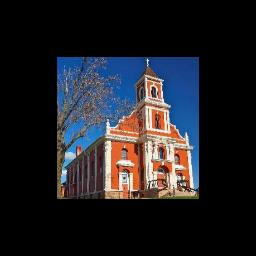

encoded image_1(img__ob1): 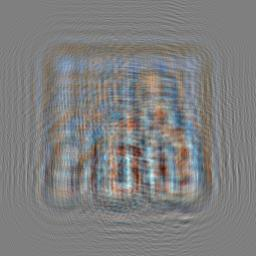

encoded image_2(img__ob2): 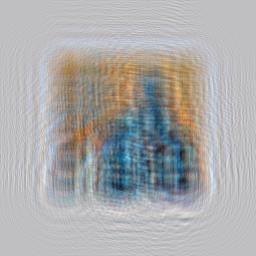

# Experimental parameter setting

In [ ]:
dp=0.014
di=3
z1=300
r1=0.23
M=di/z1
ri=(1+M)*r1
  
NX,NY=256,256

fu_max,fv_max=0.5/dp,0.5/dp
du,dv=2*fu_max/NX,2*fv_max/NY
u,v=np.mgrid[-fu_max:fu_max:du,-fv_max:fv_max:dv]
u=u.T
v=v.T
H1=1j*(np.exp(-1j*(np.dot(np.pi,ri**2))*(u**2+v**2)))
H2=1j*(np.exp(-1j*(np.dot(np.pi,ri**2))*(u**2+v**2)+1j*0.5*np.pi))

# `MLDM_reconstruction_simulate.get_pc_sample` Indicates a rebuild function

In [ ]:
img_size = config.data.image_size 
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)

sampling_fn = MLDM_reconstruction_simulate.get_pc_sampler(sde, shape, predictor, corrector,
                                    inverse_scaler, snr, n_steps=n_steps,
                                    probability_flow=probability_flow,
                                    continuous=config.training.continuous,
                                    eps=sampling_eps, device=config.device)

x,psnr_max,ssim_max = sampling_fn(score_model,img,H1,H2,img_ob1,img_ob2)

x_min=x.min()
x_max=x.max()
x=(x-x_min)/(x_max-x_min)

print('PSNR:',psnr_max)
print('SSIM:',ssim_max)

show_samples(x*255)

# Reconstructed image

PSNR:27.87

SSIM:0.925

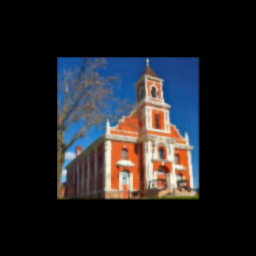